In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import seaborn
import networkx
from grave import grave
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import cartopy.crs
from cartopy.io.img_tiles import OSM
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
from scipy.cluster import hierarchy
import screed
#import os
import pyprind

Populating the interactive namespace from numpy and matplotlib


In [2]:
metadata = pandas.read_csv( 'data/Table1_5_combined.txt', sep='\t', 
                      dtype={'Body_site':str, 'POGs_SUBFAMILY':str} )
metadata.head()

,UViG,TAXON_OID,Scaffold_ID,VIRAL_CLUSTERS,Ecosystem,Ecosystem_Category,Ecosystem_Type,Ecosystem_Subtype,Habitat,Body_site,...,Host,Host_detection,Host_domain,Estimated_completeness,Quality,POGs_ORDER,POGs_FAMILY,POGs_SUBFAMILY,POGs_GENUS,putative_retrovirus
0,2003000007_____2003296998,2003000007,2003296998,sg_24096,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
1,2003000007_____2003297061,2003000007,2003297061,sg_24097,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
2,2003000007_____2003297087,2003000007,2003297087,sg_24098,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
3,2003000007_____2003297164,2003000007,2003297164,sg_24099,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
4,2003000007_____2003297262,2003000007,2003297262,sg_24100,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,NaN,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN


In [3]:
lastal_cols = [ 'query_id', 'subject_id', 'identity', 'alignment_length',
                'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start',
                's_end', 'evalue', 'bitscore', 'query_length', 'subject_length',
                'raw_score' ]

df = pandas.read_csv( 'data/spacers_vs_all_viral_sequences_combined_v2_Filtered_1Snp_100AF.lout', 
                      sep='\t', names=lastal_cols, index_col=False )

# merge viral clusters
clusters = metadata[ ['UViG', 'VIRAL_CLUSTERS'] ]
clusters.columns = [ 'subject_id', 'vcluster' ]
df = df.merge( clusters, on='subject_id' )

# merge CRISPR array
df['CRISPR_array'] = [ ':'.join(name.split(':')[:2]) for name in df.query_id ]

print(df.shape)
df.head()

(90108, 17)


,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length,raw_score,vcluster,CRISPR_array
0,637000024:NC_003228:2:2998261,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,637000024:NC_003228
1,637000024:NC_003228:2:2998455,7000000526_____SRS019397_WUGC_scaffold_4145,97.06,34,1,0,1,34,22655,22688,2.500000e-07,52.2,34,47940,32,sg_282454,637000024:NC_003228
2,647533110:NZ_GG705213:1:413342,7000000526_____SRS019397_WUGC_scaffold_4145,96.67,30,1,0,30,1,34447,34476,3.200000e-05,45.9,30,47940,28,sg_282454,647533110:NZ_GG705213
3,650377910:FQ312004:2:4712990,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,30,0,0,1,30,29564,29593,1.800000e-06,49.0,30,47940,30,sg_282454,650377910:FQ312004
4,2571042234:JGEV01000024:2:689262,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,2571042234:JGEV01000024


In [4]:
v2h_taxonomy = pandas.read_csv( 'data/predicted_hosts.tsv', sep='\t' )

df['host_img_oid'] = [ int(i.split(':')[0]) for i in df['CRISPR_array'] ]

df = df.merge( v2h_taxonomy, left_on='host_img_oid', right_on='Host_Taxon_ID' )

In [26]:
from Bio import SeqIO
import gzip

spacer_records = [ r.id for r in SeqIO.parse( open( 'data/viral_spacers.fna' ), 'fasta' ) ]
metaspacer_records = [ r.id for r in SeqIO.parse( gzip.open( 'data/meta_spacers.fna.gz', 'rt' ), 'fasta' ) ]

In [27]:
len(metaspacer_records)

26852016

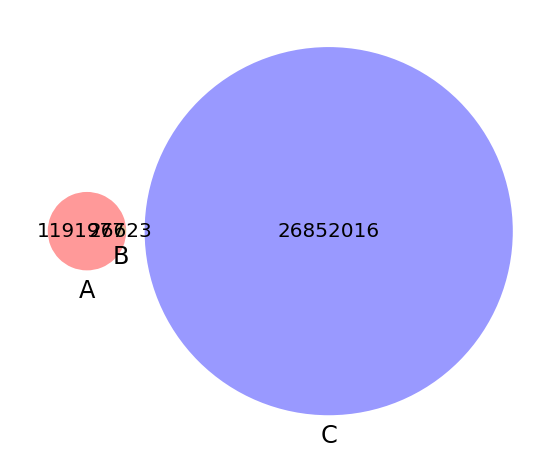

In [28]:
from matplotlib_venn import venn2, venn3

venn3( [set(spacer_records), set(df.query_id), set(metaspacer_records) ] )

In [6]:
G = networkx.convert_matrix.from_pandas_edgelist( df, 'CRISPR_array', 'vcluster', 'bitscore' )

networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'type':'CRISPR_array'} for name in df.query_id } )
networkx.set_node_attributes( G, { name : {'type':'vcluster'} for name in df.vcluster } )

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

22222